## Importing Packages

In [70]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Dataset and Dataloader Instantiation

In [71]:
class ColorizationDataset(Dataset):
    def __init__(self, image_folder):
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', 'png', '.bmp'))]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_bgr = cv2.imread(self.image_paths[idx])
        img_bgr = cv2.resize(img_bgr, (64, 64))
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)

        L = img[:, :, 0] / 255
        
        ab = (img[:, :, 1:] - 128) / 128
        L = torch.from_numpy(L).unsqueeze(0).float()
        ab = torch.from_numpy(ab).permute(2,0,1).float()

        return L, ab

In [72]:
from torch.utils.data import DataLoader, random_split

dataset = ColorizationDataset(image_folder = 'data')

total_size = len(dataset)
train_size = int(.7 * total_size)
test_size = total_size - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 4, drop_last = True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = True, num_workers = 4, drop_last = True)

## Dataset Visualization

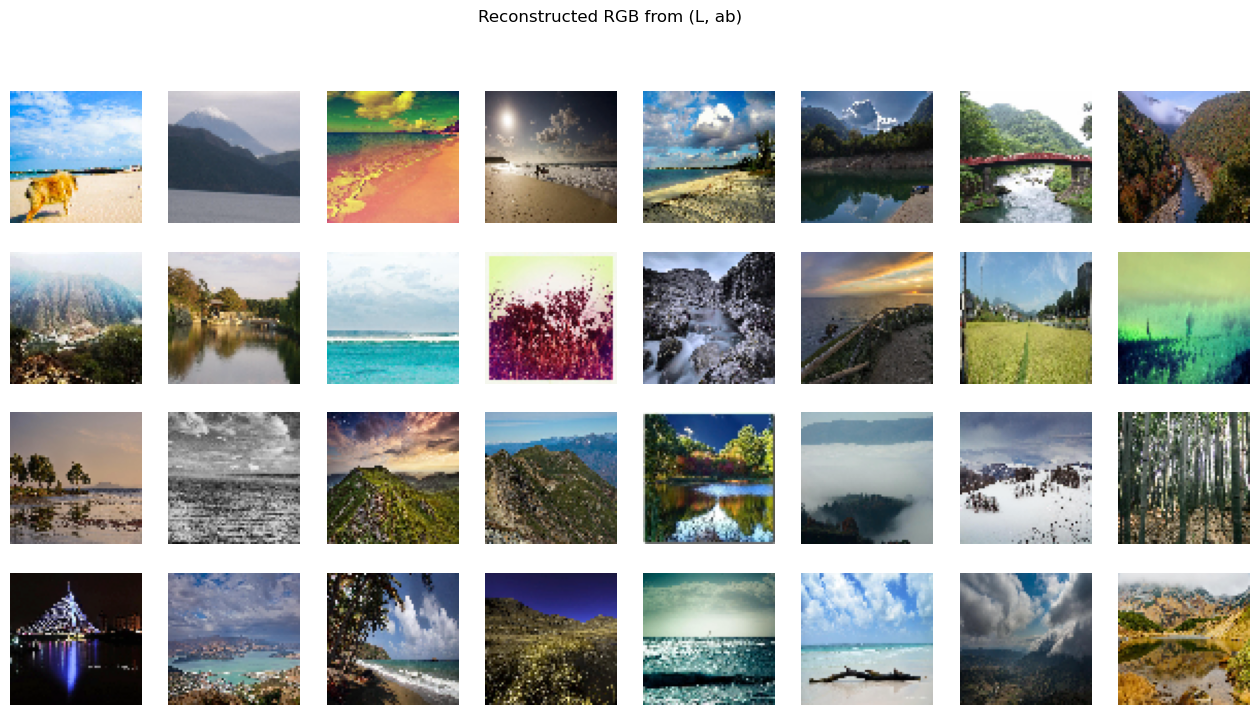

In [73]:
L_batch, ab_batch = next(iter(train_loader))

def lab_to_rgb(L, ab):
    L = np.squeeze(L)
    ab = np.transpose(ab, (1,2,0)) if ab.ndim == 3 else ab
    L = L * 255
    ab = (ab * 128) + 128
    lab = np.concatenate([L[..., np.newaxis], ab], axis = 2).astype(np.uint8)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb


plt.figure(figsize = (16,8))
for i in range(32):
    L = L_batch[i].numpy()
    ab = ab_batch[i].numpy()
    rgb = lab_to_rgb(L, ab)

    plt.subplot(4,8,i+1)
    plt.imshow(rgb)
    plt.axis('off')
    
plt.suptitle("Reconstructed RGB from (L, ab)")
plt.show()

## Loading Models

In [74]:
from models import UNet, PatchGAN
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
G = UNet(in_channels = 1, out_channels = 2).to(device)
D = PatchGAN(in_channels = 3).to(device)

## Defining Hyperparameters

In [75]:
lr = 2e-4 
num_epochs = 100
lambda_l1 = 100

opt_G = optim.Adam(G.parameters(), lr = lr, betas = (0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr = lr, betas = (0.5, 0.999))

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

## Training

In [76]:
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    G_loss = 0
    D_loss = 0

    for L, ab in train_loader:
        L, ab = L.to(device), ab.to(device)

        fake_ab = G(L)

        opt_D.zero_grad()
        real = torch.cat([L, ab], dim = 1)
        fake = torch.cat([L, fake_ab.detach()], dim = 1)

        pred_real = D(real)
        pred_fake = D(fake)
        loss_D = 0.5 * (criterion_GAN(pred_real, torch.ones_like(pred_real)) + criterion_GAN(pred_fake, torch.zeros_like(pred_fake)))
        loss_D.backward()
        opt_D.step()


        opt_G.zero_grad()
        pred_fake = D(torch.cat([L, fake_ab], dim = 1))
        loss_G_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
        loss_G_L1 = criterion_L1(fake_ab, ab)
        loss_G = loss_G_GAN + lambda_l1 * loss_G_L1
        loss_G.backward()
        opt_G.step()

        D_loss += loss_D.item()
        G_loss += loss_G.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}] \n D_loss: {D_loss/len(train_loader):.4f} \n G_loss: {G_loss/len(train_loader):.4f}')
    G_losses.append(G_loss)
    D_losses.append(D_loss)

Epoch [1/100] 
 D_loss: 0.5486 
 G_loss: 9.4185
Epoch [2/100] 
 D_loss: 0.3503 
 G_loss: 9.5270
Epoch [3/100] 
 D_loss: 0.2325 
 G_loss: 9.8181
Epoch [4/100] 
 D_loss: 0.1888 
 G_loss: 9.9484
Epoch [5/100] 
 D_loss: 0.3312 
 G_loss: 9.8193
Epoch [6/100] 
 D_loss: 0.3764 
 G_loss: 9.8649
Epoch [7/100] 
 D_loss: 0.4558 
 G_loss: 9.9019
Epoch [8/100] 
 D_loss: 0.5094 
 G_loss: 9.7300
Epoch [9/100] 
 D_loss: 0.5123 
 G_loss: 9.5386
Epoch [10/100] 
 D_loss: 0.4982 
 G_loss: 9.5959
Epoch [11/100] 
 D_loss: 0.4975 
 G_loss: 9.5954
Epoch [12/100] 
 D_loss: 0.5043 
 G_loss: 9.5834
Epoch [13/100] 
 D_loss: 0.5006 
 G_loss: 9.5536
Epoch [14/100] 
 D_loss: 0.5001 
 G_loss: 9.6181
Epoch [15/100] 
 D_loss: 0.4897 
 G_loss: 9.5623
Epoch [16/100] 
 D_loss: 0.4896 
 G_loss: 9.6164
Epoch [17/100] 
 D_loss: 0.4836 
 G_loss: 9.6339
Epoch [18/100] 
 D_loss: 0.4939 
 G_loss: 9.5123
Epoch [19/100] 
 D_loss: 0.5004 
 G_loss: 9.6597
Epoch [20/100] 
 D_loss: 0.4854 
 G_loss: 9.6299
Epoch [21/100] 
 D_loss: 0.50

## Inference

In [77]:
import torchvision.utils as vutils

G.eval()
L_batch, ab_batch = next(iter(test_loader))
L_batch = L_batch.to(device)
ab_batch = ab_batch.to(device)

def lab_to_rgb(L, ab):
    L = L.squeeze(0).cpu().numpy() * 100
    ab = ab.cpu().numpy() * 128
    lab = np.zeros((L.shape[0], L.shape[1], 3), dtype=np.float32)
    lab[:, :, 0] = L
    lab[:, :, 1:] = ab.transpose(1, 2, 0)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return np.clip(rgb, 0, 1)
    
with torch.no_grad():
    ab_fake_batch = G(L_batch)

real_rgb_list = []
fake_rgb_list = []

for i in range(min(16, L_batch.size(0))):
    L = L_batch[i]
    ab_real = ab_batch[i]
    ab_fake = ab_fake_batch[i]

    real_rgb = lab_to_rgb(L, ab_real)
    fake_rgb = lab_to_rgb(L, ab_fake)

    real_rgb_list.append(torch.from_numpy(real_rgb.transpose(2, 0, 1)))
    fake_rgb_list.append(torch.from_numpy(fake_rgb.transpose(2, 0, 1)))


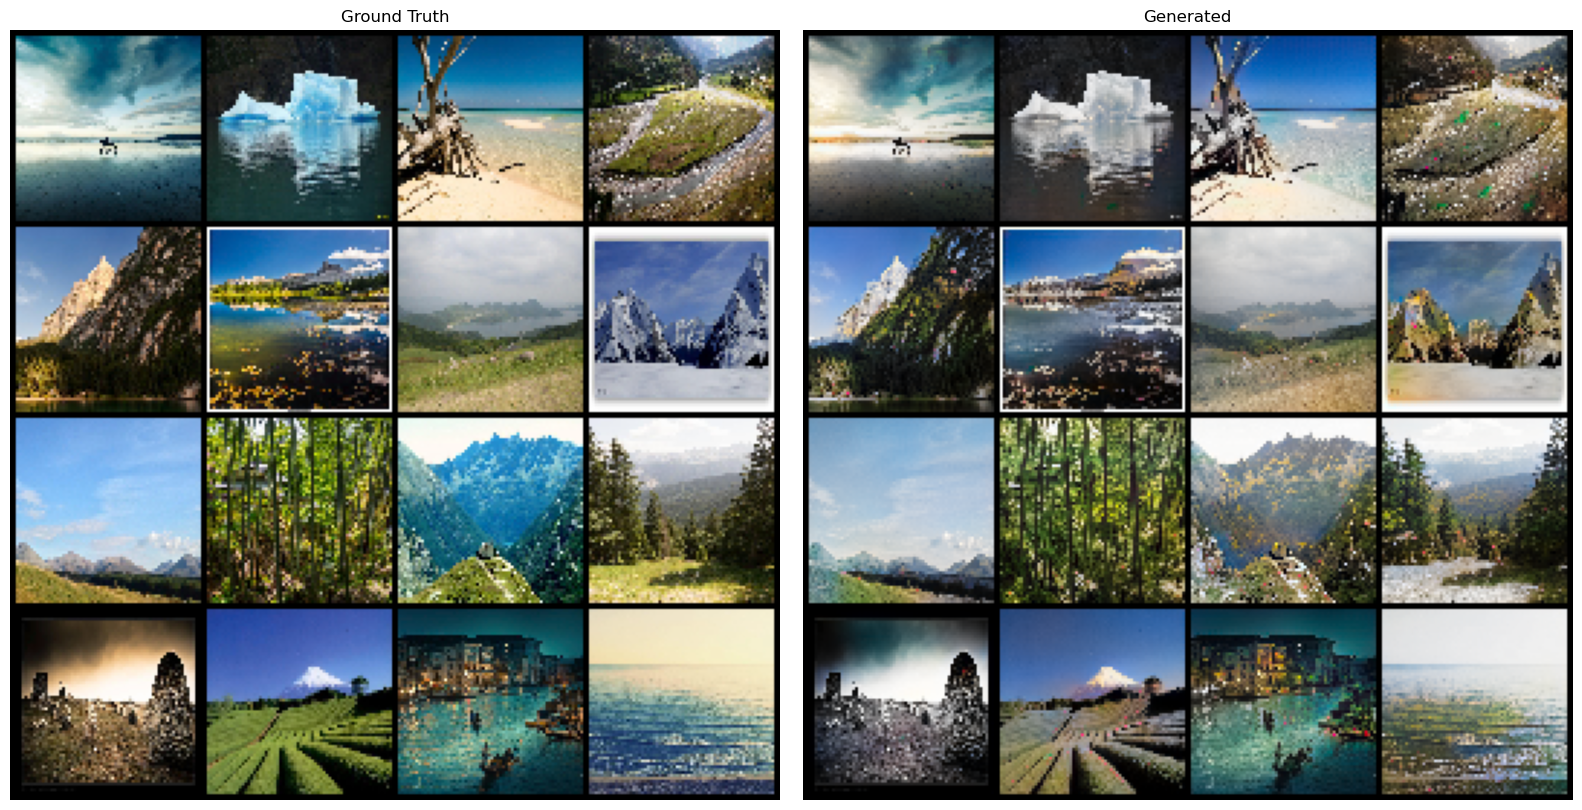

In [78]:
real_grid = vutils.make_grid(real_rgb_list, nrow=4, padding=2)
fake_grid = vutils.make_grid(fake_rgb_list, nrow=4, padding=2)

plt.figure(figsize=(16, 8))


plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Ground Truth')
plt.imshow(np.transpose(real_grid.numpy(), (1, 2, 0)))


plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Generated')
plt.imshow(np.transpose(fake_grid.numpy(), (1, 2, 0)))

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Generative and Discriminative Loss over Training')

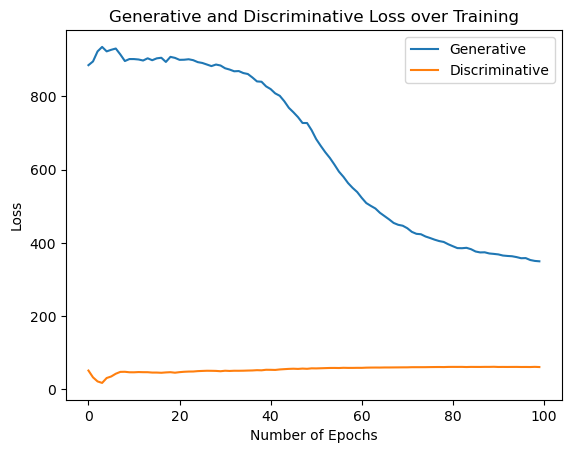

In [82]:
plt.plot(G_losses, label = 'Generative')
plt.plot(D_losses, label = 'Discriminative')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Generative and Discriminative Loss over Training')